In [1]:
!echo "Loading data"
!pip install gdown
!gdown https://drive.google.com/uc?id=1qNpH_0BEy-JJE5VMNfb8kuNN2KfsFLsi
!unzip Images.zip

Loading data
Downloading...
From: https://drive.google.com/uc?id=1qNpH_0BEy-JJE5VMNfb8kuNN2KfsFLsi
To: /content/Images.zip
100% 7.85M/7.85M [00:00<00:00, 73.4MB/s]
Archive:  Images.zip
   creating: Images/
  inflating: Images/slice001.nii.gz  
  inflating: Images/slice002.nii.gz  
  inflating: Images/slice003.nii.gz  
  inflating: Images/slice004.nii.gz  
  inflating: Images/slice005.nii.gz  
  inflating: Images/slice006.nii.gz  
  inflating: Images/slice007.nii.gz  
  inflating: Images/slice008.nii.gz  
  inflating: Images/slice009.nii.gz  
  inflating: Images/slice010.nii.gz  
  inflating: Images/slice011.nii.gz  
  inflating: Images/slice012.nii.gz  
  inflating: Images/slice013.nii.gz  
  inflating: Images/slice014.nii.gz  
  inflating: Images/slice015.nii.gz  
  inflating: Images/slice016.nii.gz  
  inflating: Images/slice017.nii.gz  
  inflating: Images/slice018.nii.gz  
  inflating: Images/slice019.nii.gz  
  inflating: Images/slice020.nii.gz  
  inflating: Images/slice021.nii.g

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image,ImageDraw
from scipy.spatial import ConvexHull
from skimage import measure

In [10]:
def show_slice(slice):
  plt.figure()
  plt.imshow(slice.T,cmap="gray",origin="lower")

def show_slice_window(slice,level,window):
  max = level  + window/2
  min = level - window/2

  slice=slice.clip(min,max)
  show_slice(slice)
  plt.figure()
  plt.imshow(slice.T, cmap="gray", origin="lower")
  plt.savefig('L'+str(level)+'W'+str(window))

def overlay_plot(im, mask):
    plt.figure()
    plt.imshow(im.T, 'gray', interpolation='none')
    plt.imshow(mask.T, 'jet', interpolation='none', alpha=0.5)



In [11]:
import glob
basepath = './Images/slice*.nii.gz'
paths = sorted(glob.glob(basepath))
print('Images found:', len(paths))

Images found: 21


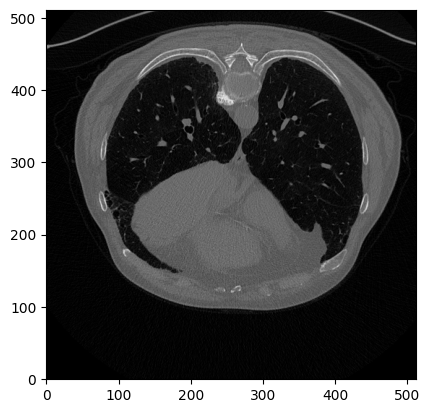

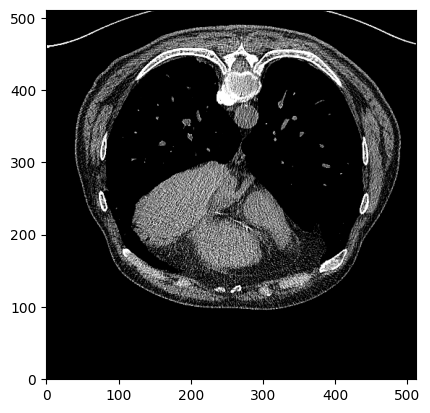

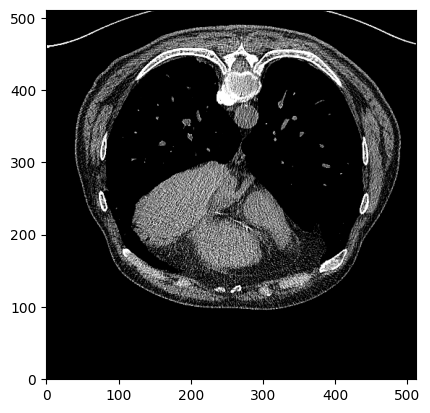

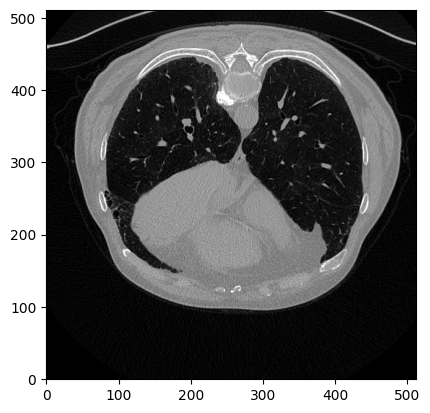

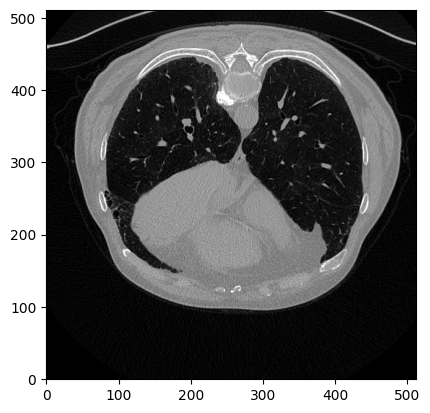

In [12]:
import nibabel as nib
for c, exam_path in enumerate(paths):
    ct_img = nib.load(exam_path)
    ct_numpy = ct_img.get_fdata()

    if c == 1:
      show_slice(ct_numpy)
      plt.savefig('original')
      show_slice_window(ct_numpy,+50,350)
      show_slice_window(ct_numpy,-200,2000)
      break

slice001 lung area: 14218.815117879074
slice002 lung area: 34572.27296447754
slice003 lung area: 31513.963623046875
slice004 lung area: 33388.04453495125
slice005 lung area: 32391.739428426652
slice006 lung area: 32086.478447489502
slice007 lung area: 17640.84075957298
slice008 lung area: 26042.239642517397
slice009 lung area: 31255.91289323208
slice010 lung area: 24475.454391479492
slice011 lung area: 18455.89931488037
slice012 lung area: 25330.21658706665
slice013 lung area: 30042.837661743164
slice014 lung area: 30310.75862121582
slice015 lung area: 25977.577117919922
slice016 lung area: 27387.329864501953
slice017 lung area: 15523.084259033203
slice018 lung area: 29196.441650390625
slice019 lung area: 4298.816299438477
slice020 lung area: 12907.887268066406
slice021 lung area: 11454.214477539062


/tmp/ipython-input-2537834016.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
/tmp/ipython-input-1921145352.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Specify denoise=False in create_vessel_mask for quick and noisy results.
Otherwise wait a couple of minutes :)
slice001 Vessel %: 2.2451221087995865
slice002 Vessel %: 3.6643426472423815
slice003 Vessel %: 2.323943661971831
slice004 Vessel %: 2.712665648385968
slice005 Vessel %: 2.2762854680106246
slice006 Vessel %: 3.126406404105982
slice007 Vessel %: 2.9513865438385585
slice008 Vessel %: 3.808181826499894
slice009 Vessel %: 2.1884959391384804
slice010 Vessel %: 5.3276199473648695
slice011 Vessel %: 3.913929208046855
slice012 Vessel %: 6.098669684769097
slice013 Vessel %: 3.394685023352699
slice014 Vessel %: 2.456570479216736
slice015 Vessel %: 2.576504686264915
slice016 Vessel %: 2.76259480530486
slice017 Vessel %: 4.732002691186365
slice018 Vessel %: 3.48966613672496
slice019 Vessel %: 4.103117829666622
slice020 Vessel %: 7.433960653778859
slice021 Vessel %: 6.309512359334423
Centers 2D: [[13499.9367852    593.63437113]
 [29569.37624489   955.65534174]]
Slice labels: [0 1 1 1 1 1 0 

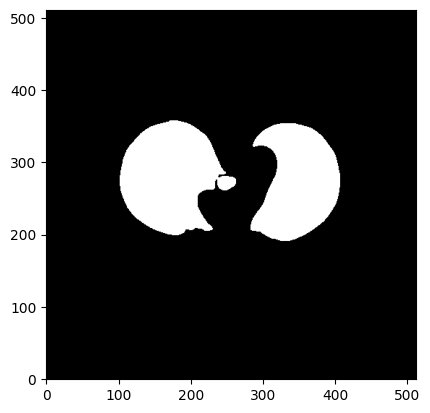

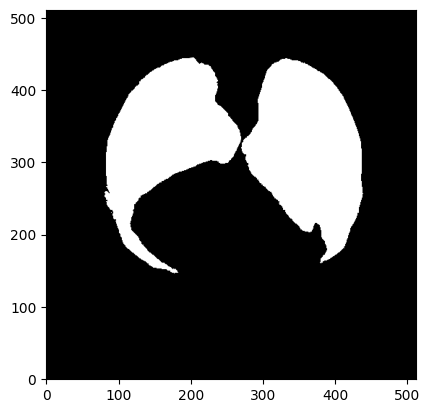

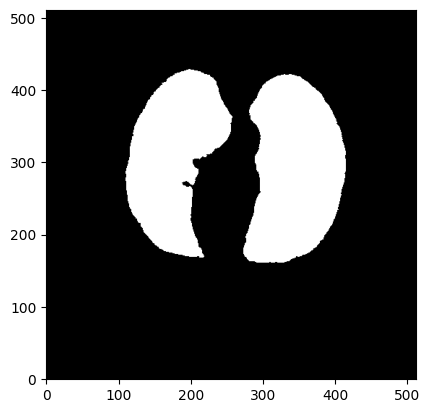

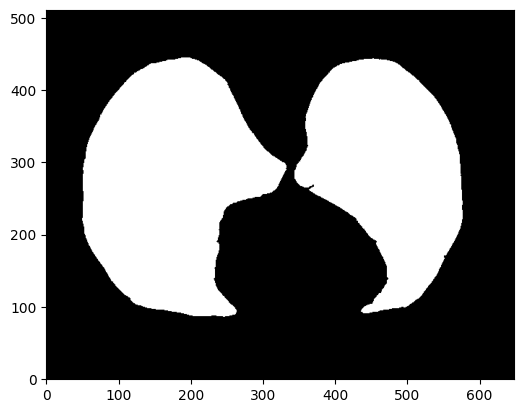

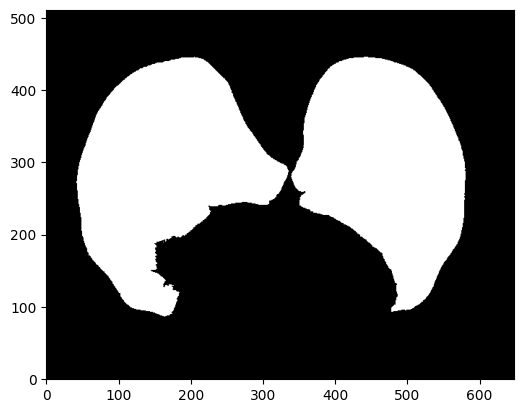

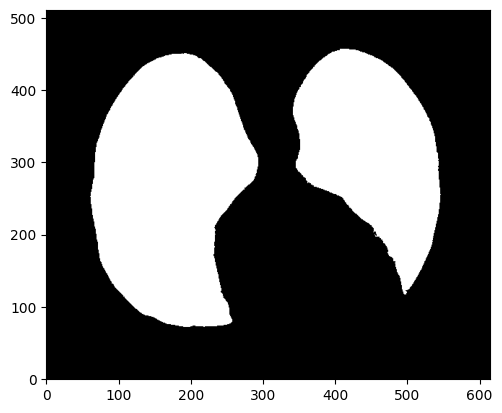

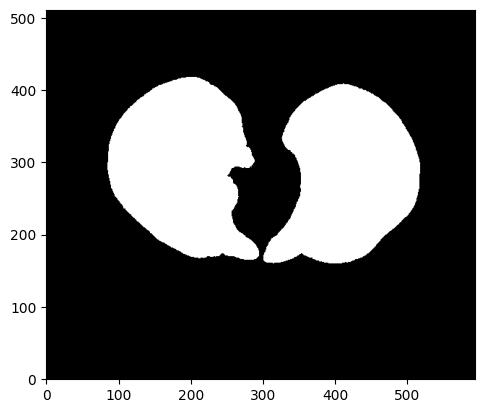

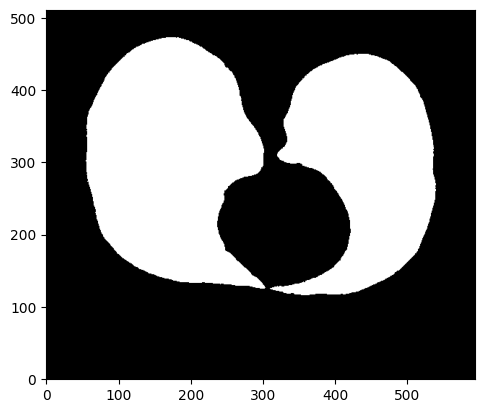

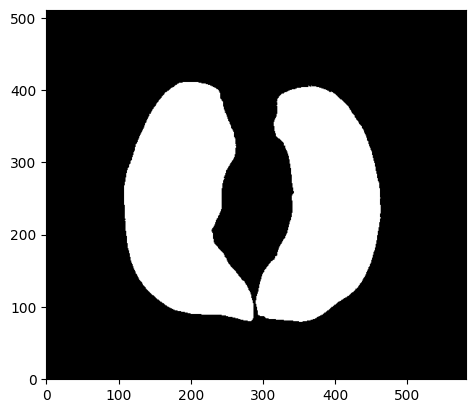

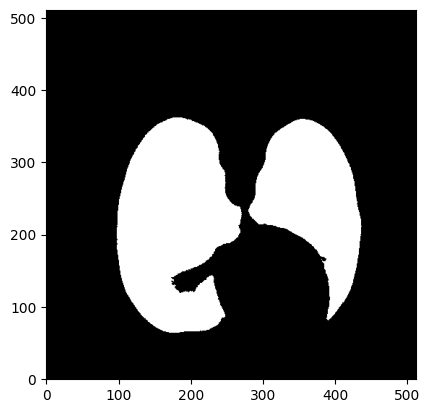

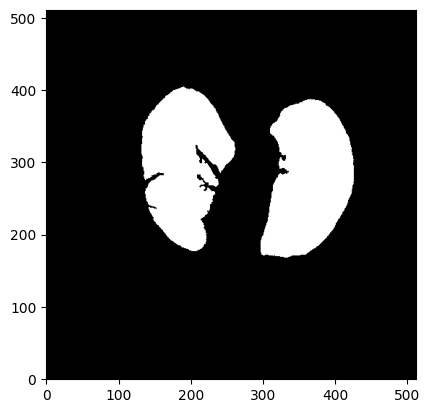

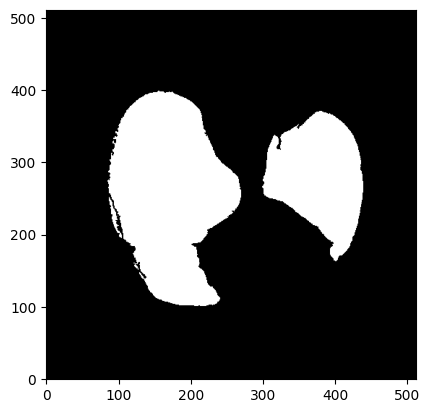

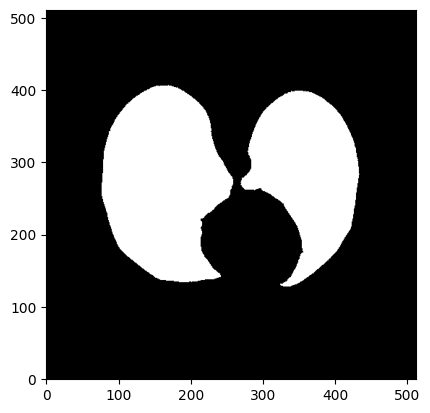

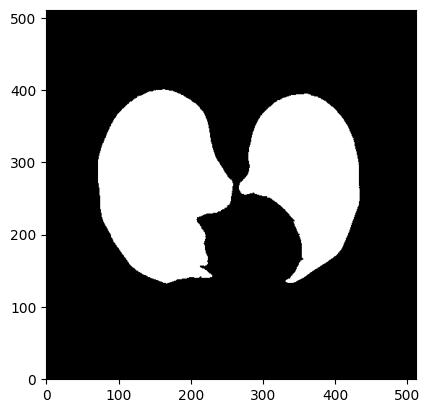

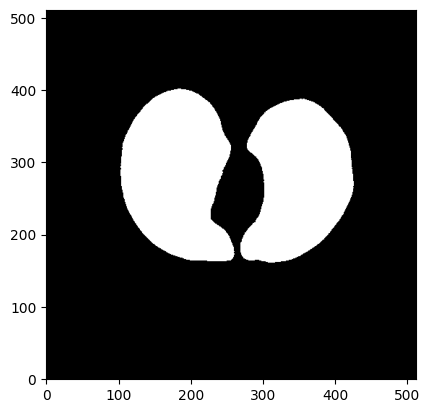

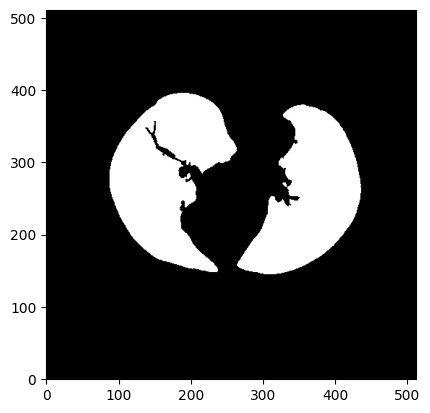

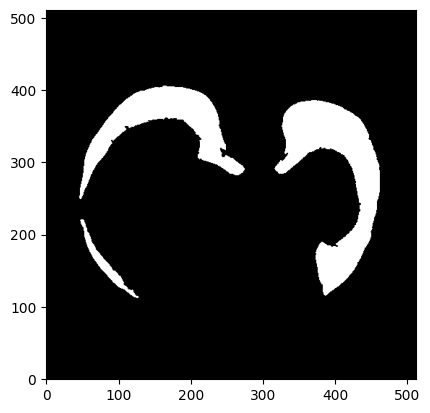

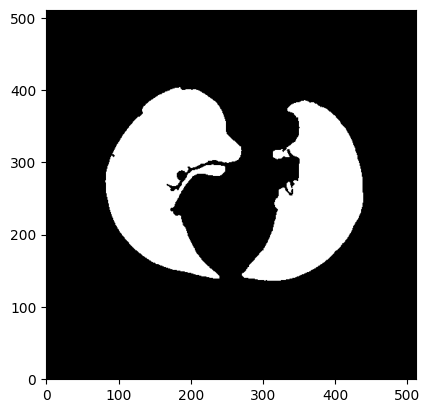

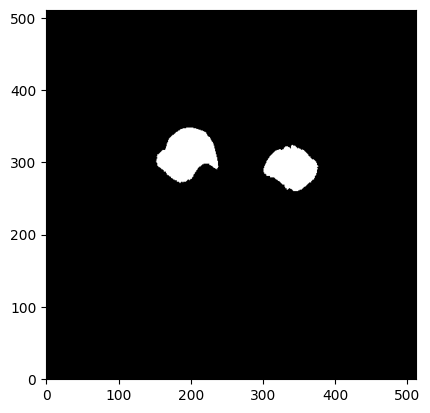

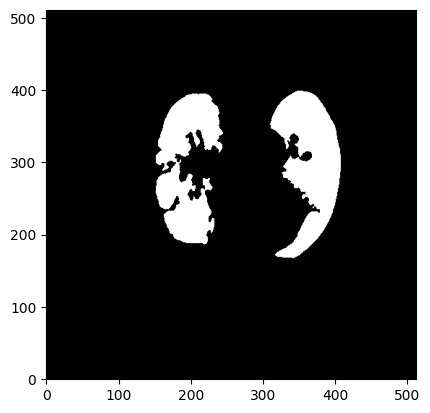

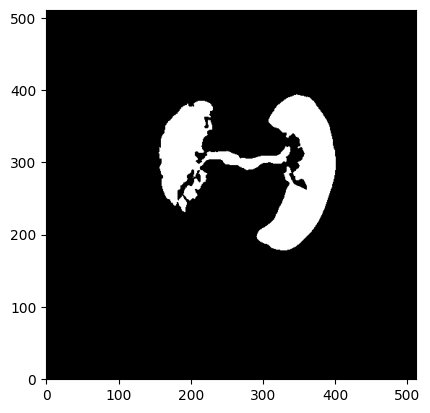

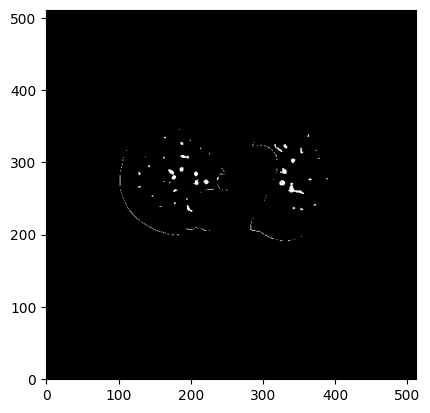

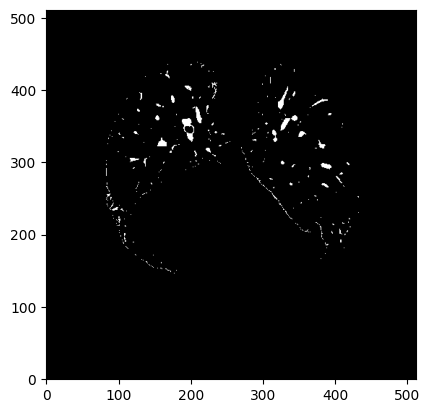

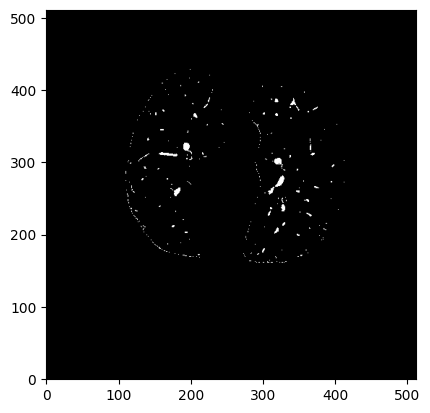

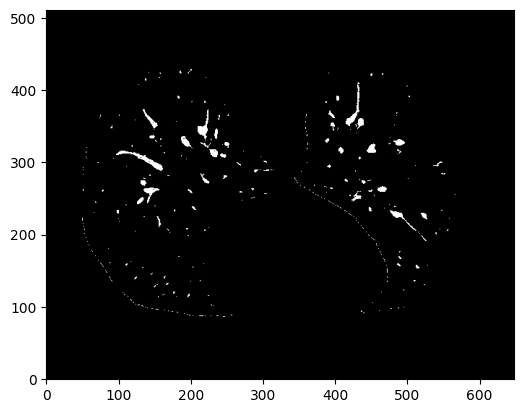

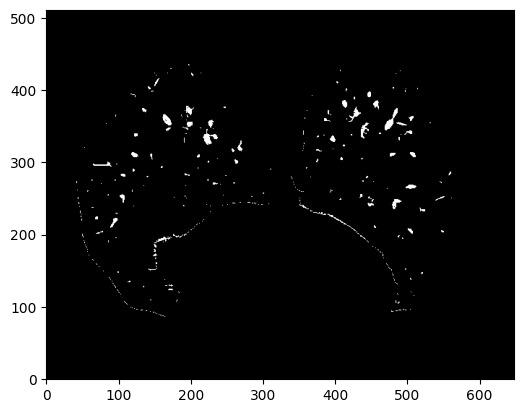

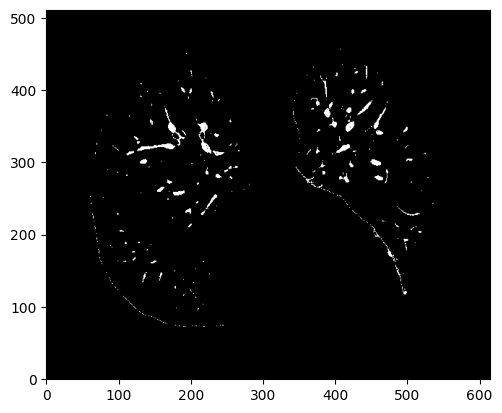

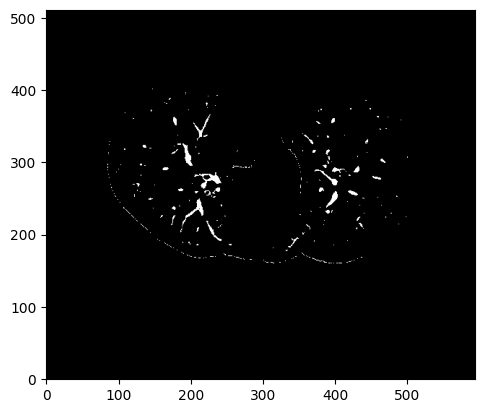

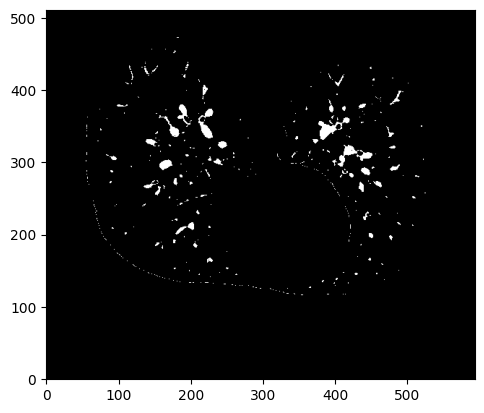

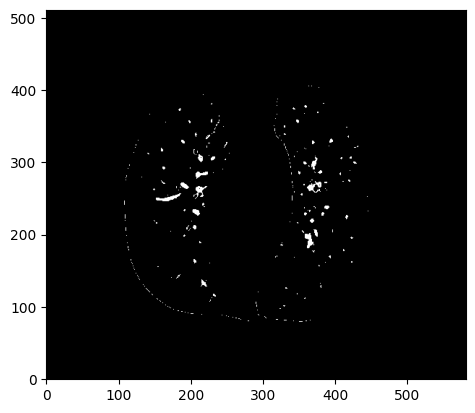

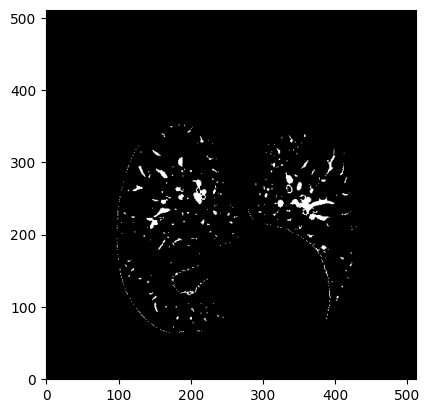

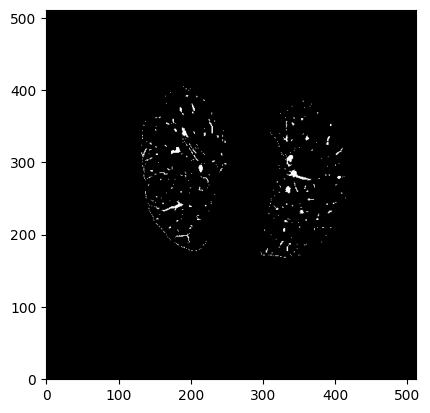

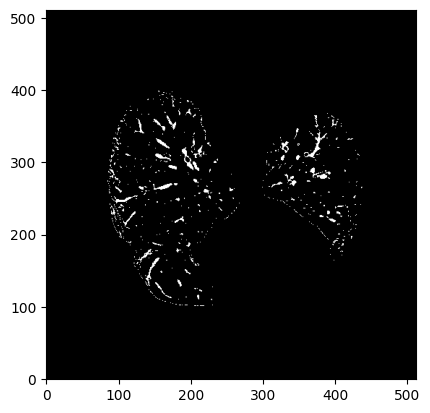

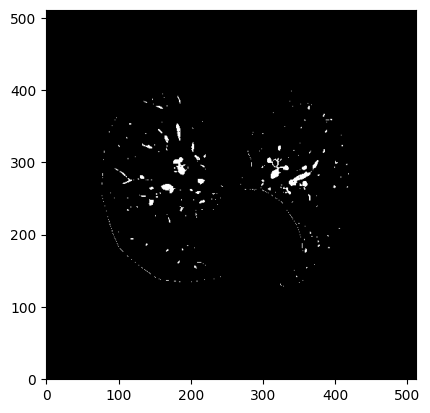

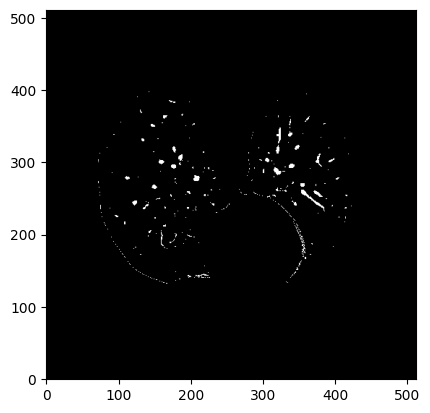

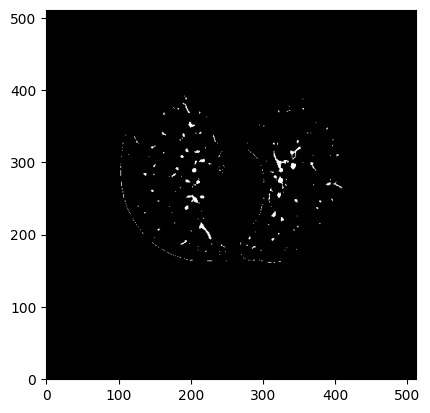

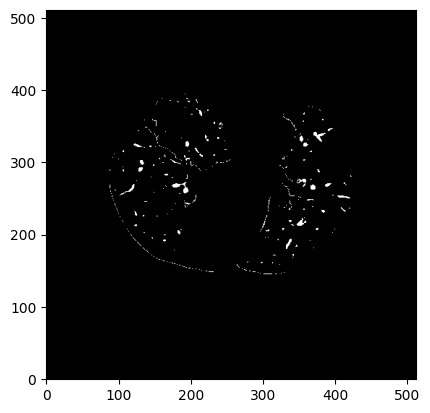

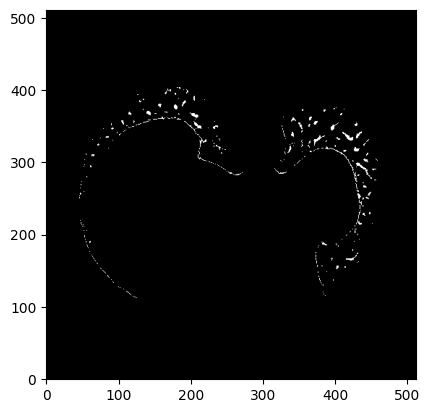

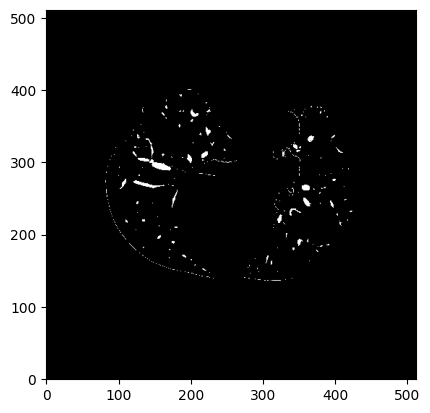

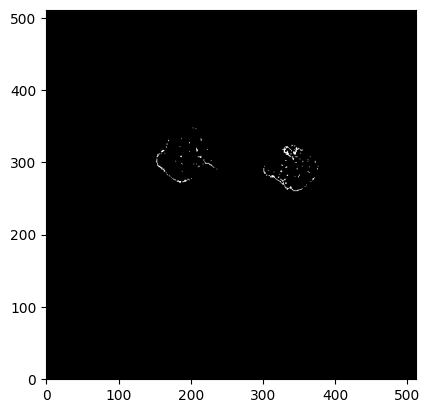

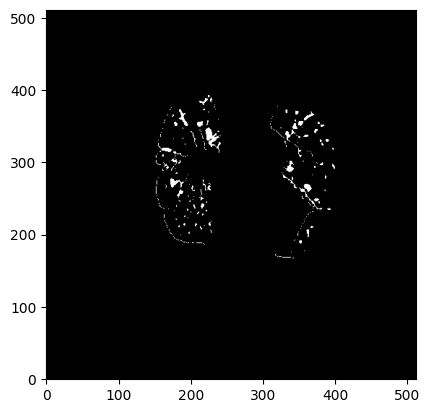

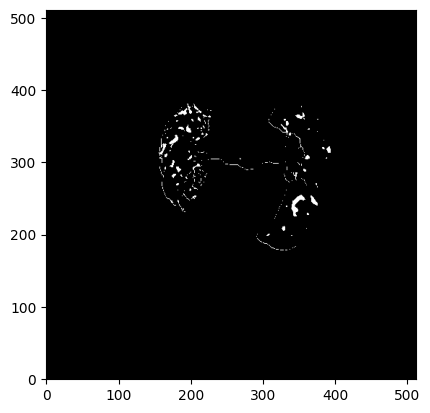

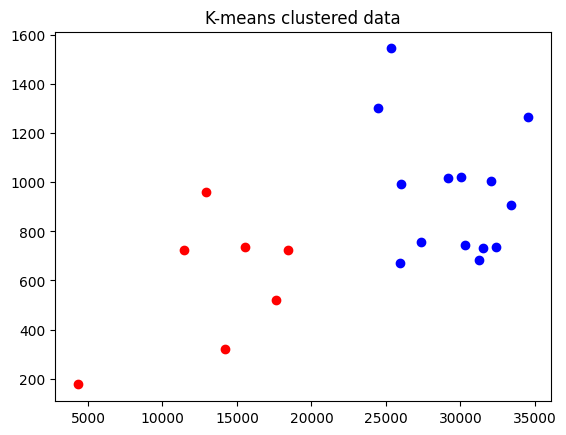

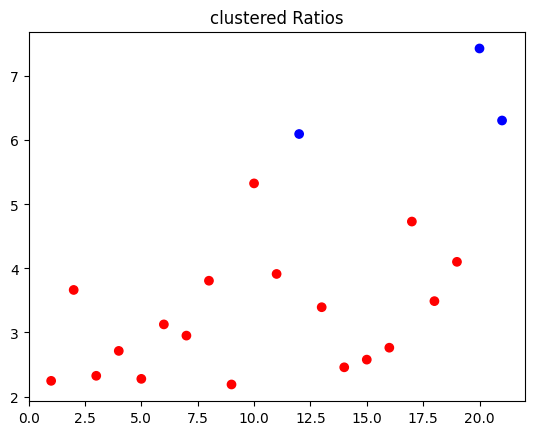

In [14]:
import shutil
import glob
import csv
def make_dirs(path):
    if os.path.exists(path):
        shutil.rmtree(path)
        os.mkdir(path)
    else:
        os.makedirs(path)

def intensity_seg(ct_numpy, min, max):
    clipped = ct_numpy.clip(min, max)
    clipped[clipped != max] = 1
    clipped[clipped == max] = 0
    return measure.find_contours(clipped, 0.95)

def set_is_closed(contour):
    if contour_distance(contour) < 1:
        return True
    else:
        return False

def find_lungs(contours):
    """
    Chooses the contours that correspond to the lungs and the body
    FIrst we exclude non closed sets-contours
    Then we assume some min area and volume to exclude small contours
    Then the body is excluded as the highest volume closed set
    The remaining areas correspond to the lungs

    Args:
        contours: all the detected contours

    Returns: contours that correspond to the lung area

    """
    body_and_lung_contours = []
    vol_contours = []

    for contour in contours:
        hull = ConvexHull(contour)

        if hull.volume > 2000 and set_is_closed(contour):
            body_and_lung_contours.append(contour)
            vol_contours.append(hull.volume)

    if len(body_and_lung_contours) == 2:
        return body_and_lung_contours
    elif len(body_and_lung_contours) > 2:
        vol_contours, body_and_lung_contours = (list(t) for t in
                                                zip(*sorted(zip(vol_contours, body_and_lung_contours))))
        body_and_lung_contours.pop(-1)
        return body_and_lung_contours


def show_contour(image, contours, name=None, save=False):
    fig, ax = plt.subplots()
    ax.imshow(image.T, cmap=plt.cm.gray)
    for contour in contours:
        ax.plot(contour[:, 0], contour[:, 1], linewidth=1)

    ax.set_xticks([])
    ax.set_yticks([])

    if save:
        plt.savefig(name)
        plt.close(fig)
    else:
        plt.show()



def create_mask_from_polygon(image, contours):
    """
    Creates a binary mask with the dimensions of the image and
    converts the list of polygon-contours to binary masks and merges them together
    Args:
        image: the image that the contours refer to
        contours: list of contours

    Returns:

    """

    lung_mask = np.array(Image.new('L', image.shape, 0))
    for contour in contours:
        x = contour[:, 0]
        y = contour[:, 1]
        polygon_tuple = list(zip(x, y))
        img = Image.new('L', image.shape, 0)
        ImageDraw.Draw(img).polygon(polygon_tuple, outline=0, fill=1)
        mask = np.array(img)
        lung_mask += mask

    lung_mask[lung_mask > 1] = 1  # sanity check to make 100% sure that the mask is binary

    return lung_mask.T  # transpose it to be aligned with the image dims

def save_nifty(img_np, name, affine):
    """
    binary masks should be converted to 255 so it can be displayed in a nii viewer
    we pass the affine of the initial image to make sure it exits in the same
    image coordinate space
    Args:
        img_np: the binary mask
        name: output name
        affine: 4x4 np array
    Returns:
    """
    img_np[img_np == 1] = 255
    ni_img = nib.Nifti1Image(img_np, affine)
    nib.save(ni_img, name + '.nii.gz')


def find_pix_dim(ct_img):

    pix_dim = ct_img.header["pixdim"]
    dim = ct_img.header["dim"]
    max_indx = np.argmax(dim)
    pixdimX = pix_dim[max_indx]
    dim = np.delete(dim, max_indx)
    pix_dim = np.delete(pix_dim, max_indx)
    max_indy = np.argmax(dim)
    pixdimY = pix_dim[max_indy]
    return [pixdimX, pixdimY]

def contour_distance(contour):

    dx = contour[0, 1] - contour[-1, 1]
    dy = contour[0, 0] - contour[-1, 0]
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

def compute_area(mask, pixdim):
    mask[mask >= 1] = 1
    lung_pixels = np.sum(mask)
    return lung_pixels * pixdim[0] * pixdim[1]

outpath = './LUNGS/'
contour_path = './Contours/'
paths = sorted(glob.glob(basepath))
myFile = open('lung_volumes.csv', 'w')
lung_areas = []
make_dirs(outpath)
make_dirs(contour_path)

for c, exam_path in enumerate(paths):
    img_name = exam_path.split("/")[-1].split('.nii')[0]
    out_mask_name = outpath + img_name + "_mask"
    contour_name = contour_path + img_name + "_contour"

    ct_img = nib.load(exam_path)
    pixdim = find_pix_dim(ct_img)
    ct_numpy = ct_img.get_fdata()

    contours = intensity_seg(ct_numpy, min=-1000, max=-300)

    lungs = find_lungs(contours)
    show_contour(ct_numpy, lungs, contour_name,save=True)
    lung_mask = create_mask_from_polygon(ct_numpy, lungs)
    save_nifty(lung_mask, out_mask_name, ct_img.affine)
    show_slice(lung_mask)

    lung_area = compute_area(lung_mask, find_pix_dim(ct_img))
    lung_areas.append([img_name,lung_area]) # int is ok since the units are already mm^2
    print(img_name,'lung area:', lung_area)


with myFile:
    writer = csv.writer(myFile)
    writer.writerows(lung_areas)

!echo "Specify denoise=False in create_vessel_mask for quick and noisy results."
!echo "Otherwise wait a couple of minutes :)"
vessels = './Vessels/'
figures = './Figures/'
overlay_path = './Vessel_overlayed/'
paths = sorted(glob.glob(basepath))
myFile = open('vessel_volumes.csv', 'w')
lung_areas_csv = []
ratios = []

make_dirs(vessels)
make_dirs(overlay_path)
make_dirs(figures)

def euclidean_dist(dx, dy):
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

def denoise_vessels(lung_contour, vessels):
    vessels_coords_x, vessels_coords_y = np.nonzero(vessels)  # get non zero coordinates
    for contour in lung_contour:
        x_points, y_points = contour[:, 0], contour[:, 1]
        for (coord_x, coord_y) in zip(vessels_coords_x, vessels_coords_y):
            for (x, y) in zip(x_points, y_points):
                d = euclidean_dist(x - coord_x, y - coord_y)
                if d <= 0.1:
                    vessels[coord_x, coord_y] = 0
    return vessels


def split_array_coords(array, indx=0, indy=1):
    x = [array[i][indx] for i in range(len(array))]
    y = [array[i][indy] for i in range(len(array))]
    return x, y


def create_vessel_mask(lung_mask, ct_numpy, denoise=False):
    vessels = lung_mask * ct_numpy  # isolate lung area
    vessels[vessels == 0] = -1000
    vessels[vessels >= -500] = 1
    vessels[vessels < -500] = 0
    show_slice(vessels)
    if denoise:
        return denoise_vessels(lungs_contour, vessels)
    show_slice(vessels)

    return vessels


for c, exam_path in enumerate(paths):
    img_name = exam_path.split("/")[-1].split('.nii')[0]
    vessel_name = vessels + img_name + "_vessel_only_mask"
    overlay_name = overlay_path + img_name + "_vessels"

    ct_img = nib.load(exam_path)
    pixdim = find_pix_dim(ct_img)
    ct_numpy = ct_img.get_fdata()

    contours = intensity_seg(ct_numpy, -1000, -300)

    lungs_contour = find_lungs(contours)
    lung_mask = create_mask_from_polygon(ct_numpy, lungs_contour)

    lung_area = compute_area(lung_mask, find_pix_dim(ct_img))

    vessels_only = create_vessel_mask(lung_mask, ct_numpy, denoise=True)

    overlay_plot(ct_numpy, vessels_only)
    plt.title('Overlayed plot')
    plt.savefig(overlay_name)
    plt.close()

    save_nifty(vessels_only, vessel_name, affine=ct_img.affine)

    vessel_area = compute_area(vessels_only, find_pix_dim(ct_img))
    ratio = (vessel_area / lung_area) * 100
    print(img_name, 'Vessel %:', ratio)
    lung_areas_csv.append([img_name, lung_area, vessel_area, ratio])
    ratios.append(ratio)

# Save data to csv file
with myFile:
    writer = csv.writer(myFile)
    writer.writerows(lung_areas_csv)

# Data viz here
from sklearn.cluster import KMeans
x, y = split_array_coords(lung_areas_csv, indx=1, indy=2)
data2d = np.stack([np.asarray(x), np.asarray(y)], axis=1)

kmeans = KMeans(init="random", n_clusters=2)
kmeans.fit(data2d)
print('Centers 2D:', kmeans.cluster_centers_)
print('Slice labels:', kmeans.labels_)

class1 = [data2d[i, :] for i in range(len(kmeans.labels_)) if kmeans.labels_[i] == 0]
class2 = [data2d[i, :] for i in range(len(kmeans.labels_)) if kmeans.labels_[i] == 1]

plt.figure()
x, y = split_array_coords(class1)
plt.scatter(x, y, c='r')
x, y = split_array_coords(class2)
plt.scatter(x, y, c='b')
plt.title('K-means clustered data')
plt.savefig('kmeans-clustered')

plt.figure()
x, _ = split_array_coords(lung_areas_csv, indx=3, indy=2)
plt.scatter(x, np.arange(len(x)))
plt.title('Ratios of different slices')
plt.savefig('./Ratios')
plt.close()

# assign categories
categories = np.zeros(len(x), dtype=int)

for c, i in enumerate(x):
    if i > 6:
        categories[c] = int(1)

colormap = np.array(['r', 'b'])

plt.figure()
plt.scatter(np.arange(len(x)) + 1, x, c=colormap[categories])
plt.title('clustered Ratios')
plt.savefig('./clustered_ratios')